In [43]:

### System
import os
import joblib

### Set seed
import random
random.seed(42)

### Mains
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
%matplotlib inline 


# ### Models:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

### Ensemble Models:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier


### Dats Splits 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

### Pipelines
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.utils import shuffle

# # Sampling Methods
# from imblearn.over_sampling import SMOTE, RandomOverSampler
# from imblearn.under_sampling import NearMiss, RandomUnderSampler

### Metrics:
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



### Helper functions

In [44]:
def process_datatypes(df):
    # Format dates
    df["transDate"] = pd.to_datetime(df["transDate"])
    df["dateOfBirth"] = pd.to_datetime(df["dateOfBirth"], format="%Y-%m-%d")
    df["unixTime"] = pd.to_datetime(df["unixTime"], unit="s")

    # Format categories
    df["business"] = df["business"].astype("category")
    df["category"] = df["category"].astype("category")
    df["gender"] = df["gender"].astype("category")
    df["city"] = df["city"].astype("category")
    df["state"] = df["state"].astype("category")
    df["job"] = df["job"].astype("category")

    # Format strings
    df["creditCardNum"] = df["creditCardNum"].astype(str)
    df["firstName"] = df["firstName"].astype(str)
    df["lastName"] = df["lastName"].astype(str)
    df["street"] = df["street"].astype(str)
    df["zip"] = df["zip"].astype(str)
    df["transNum"] = df["transNum"].astype(str)

    # Format bool
    df["isFraud"] = df["isFraud"].astype(bool)

    # Fix UNIX time
    df["transDate"] = df["unixTime"] + pd.DateOffset(years=7)
    df.drop(columns=["unixTime"], inplace=True)


from vincenty import vincenty_inverse


def distance_from_home(row):
    coords_home = (row["longitude"], row["latitude"])
    coords_purchase = (row["merchLongitude"], row["merchLatitude"])

    return vincenty_inverse(coords_home, coords_purchase).km


def calcuate_distances(df):
    df["distance_customer_merchant"] = df.apply(distance_from_home, axis=1)


def calculate_fraudrates(df):
    # encode city
    grouped_transactions = df.groupby("city")
    total_transactions = grouped_transactions.size()
    fraud_transactions = grouped_transactions["isFraud"].sum()
    fraud_rate = (fraud_transactions / total_transactions) * 100
    result_dict = fraud_rate.to_dict()

    df["city_fraudrate"] = df["city"].map(result_dict)
    df.drop(columns=["city"], inplace=True)

    # encode job
    grouped_transactions = df.groupby("job")
    total_transactions = grouped_transactions.size()
    fraud_transactions = grouped_transactions["isFraud"].sum()
    fraud_rate = (fraud_transactions / total_transactions) * 100
    result_dict = fraud_rate.to_dict()

    df["job_fraudrate"] = df["job"].map(result_dict)
    df.drop(columns=["job"], inplace=True)


def determine_history(df):
    df['numOfPrevFraudTxns'] = df.groupby('creditCardNum')['isFraud'].cumsum() - df['isFraud']
    df['historyOfFraud'] = (df['numOfPrevFraudTxns'] > 0).astype(int)


def process_dates(df):
    df["trans_day"] = df["transDate"].dt.dayofyear
    df["trans_weekday"] = df["transDate"].dt.weekday
    df["trans_hour"] = df["transDate"].dt.hour
    df["age_at_transaction"] = df["transDate"].dt.year - df["dateOfBirth"].dt.year
    
def drop_columns(df):
    new_df = df.drop(
        columns=[
            "creditCardNum",
            "business",
            "firstName",
            "lastName",
            "gender",
            "street",
            "zip",
            "state",
            "transNum",
            "merchLatitude",
            "merchLongitude",
            "latitude",
            "longitude",
            "dateOfBirth",
            "transDate",
        ]
    )
    return new_df

### Process The Dataset

In [45]:
df = pd.read_csv("workspace-michael/train.csv")

def process_dataset(df):
    new_df = df.copy()

    process_datatypes(new_df)
    calcuate_distances(new_df)
    calculate_fraudrates(new_df)
    determine_history(new_df)
    process_dates(new_df)

    return new_df

In [46]:
df = process_dataset(df)
df_train = drop_columns(df)

print(f"Train size {df_train.shape}")

Train size (181822, 13)


### Encode categorical data



In [47]:
def encode_categorical(df):
    df = pd.get_dummies(df, columns=["category"])
    return df


df_train = encode_categorical(df_train)

In [48]:
df_train.head()

,amount,cityPop,isFraud,distance_customer_merchant,city_fraudrate,job_fraudrate,numOfPrevFraudTxns,historyOfFraud,trans_day,trans_weekday,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,4.10,6713,False,47.229861,0.000000,0.000000,0,0,1,1,...,False,False,False,False,True,False,False,False,False,False
1,2.67,798,False,27.264981,0.000000,1.284404,0,0,1,1,...,False,False,False,False,False,False,False,True,False,False
2,22.88,337,False,116.068684,0.000000,0.000000,0,0,1,1,...,False,False,False,False,False,True,False,False,False,False
3,9.59,3032,False,80.518979,0.000000,0.000000,0,0,1,1,...,False,False,False,False,False,True,False,False,False,False
4,129.06,1925,False,65.543964,4.577465,1.186131,0,0,1,1,...,True,False,False,False,False,False,False,False,False,False


In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   amount                      181822 non-null  float64
 1   cityPop                     181822 non-null  int64  
 2   isFraud                     181822 non-null  bool   
 3   distance_customer_merchant  181822 non-null  float64
 4   city_fraudrate              181822 non-null  float64
 5   job_fraudrate               181822 non-null  float64
 6   numOfPrevFraudTxns          181822 non-null  int64  
 7   historyOfFraud              181822 non-null  int64  
 8   trans_day                   181822 non-null  int32  
 9   trans_weekday               181822 non-null  int32  
 10  trans_hour                  181822 non-null  int32  
 11  age_at_transaction          181822 non-null  int32  
 12  category_entertainment      181822 non-null  bool   
 13  category_food_

### Correlation Matrix

<Axes: >

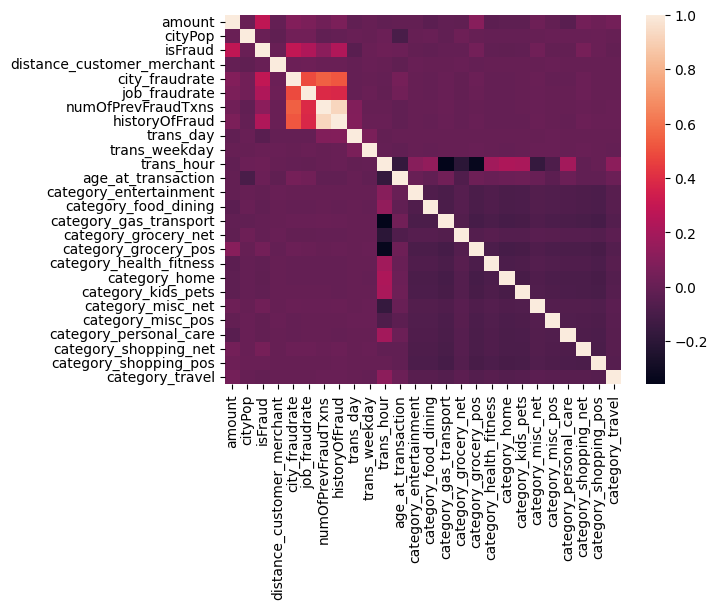

In [50]:
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, yticklabels=True)

In [51]:
corr_matrix["isFraud"].sort_values(ascending=False)

isFraud                       1.000000
city_fraudrate                0.284640
amount                        0.282902
historyOfFraud                0.231625
job_fraudrate                 0.226799
numOfPrevFraudTxns            0.114554
category_shopping_net         0.052611
category_grocery_pos          0.039221
category_misc_net             0.028487
trans_hour                    0.022698
age_at_transaction            0.013262
category_shopping_pos         0.011507
trans_weekday                 0.010622
cityPop                       0.009632
distance_customer_merchant    0.003440
category_gas_transport       -0.006114
category_grocery_net         -0.008503
category_travel              -0.009104
category_misc_pos            -0.009484
category_entertainment       -0.013400
category_personal_care       -0.014043
category_health_fitness      -0.016817
category_food_dining         -0.018768
category_kids_pets           -0.019225
category_home                -0.020704
trans_day                

### Create model traininig pipelines

- split the data 80/20

In [52]:
pipelines = {
    "LogisticRegression": make_pipeline(StandardScaler(), LogisticRegression()),
    "KNeighborsClassifier": make_pipeline(StandardScaler(), KNeighborsClassifier()),
    "RandomForestClassifier": make_pipeline(StandardScaler(), RandomForestClassifier()),
    "DecisionTreeClassifier": make_pipeline(StandardScaler(), DecisionTreeClassifier()),
    "GradientBoostingClassifier": make_pipeline(
        StandardScaler(), GradientBoostingClassifier()
    ),
}


X = df_train.drop(columns=["isFraud"])
y = df_train["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


### Fit all the models

In [53]:
fit_models = {}
for algo, pipeline in pipelines.items():
    print(f"{algo} fit check")
    model = pipeline.fit(X_train.values, y_train)
    fit_models[algo] = model
    

LogisticRegression fit check
KNeighborsClassifier fit check
RandomForestClassifier fit check
DecisionTreeClassifier fit check
GradientBoostingClassifier fit check


### Evaluate the models

- use cross validation with 10-K folds
- use of precision recall and F-1 scores

In [55]:
from sklearn.model_selection import cross_validate

results = []

for name, model in fit_models.items():
    print(f"Evaluating model: {name}")

    # Perform cross-validation and request scoring on all metrics
    scores = cross_validate(model, X, y, cv=10, scoring=['precision', 'recall', 'f1'], return_train_score=False)

    # Calculate the mean of the scores for each metric
    precision_mean = round(scores['test_precision'].mean() * 100, 2)
    recall_mean = round(scores['test_recall'].mean() * 100, 2)
    f1_mean = round(scores['test_f1'].mean() * 100, 2)

    # Append the results
    results.append({
        "Model": name,
        "Precision": precision_mean,
        "Recall": recall_mean,
        "F1 Score": f1_mean
    })

results_df = pd.DataFrame(results)
results_df


Evaluating model: LogisticRegression
Evaluating model: KNeighborsClassifier
Evaluating model: RandomForestClassifier
Evaluating model: DecisionTreeClassifier
Evaluating model: GradientBoostingClassifier


,Model,Precision,Recall,F1 Score
0,LogisticRegression,89.99,58.77,69.87
1,KNeighborsClassifier,94.21,66.55,77.68
2,RandomForestClassifier,88.88,83.68,80.52
3,DecisionTreeClassifier,79.66,83.24,76.21
4,GradientBoostingClassifier,86.30,81.81,78.55


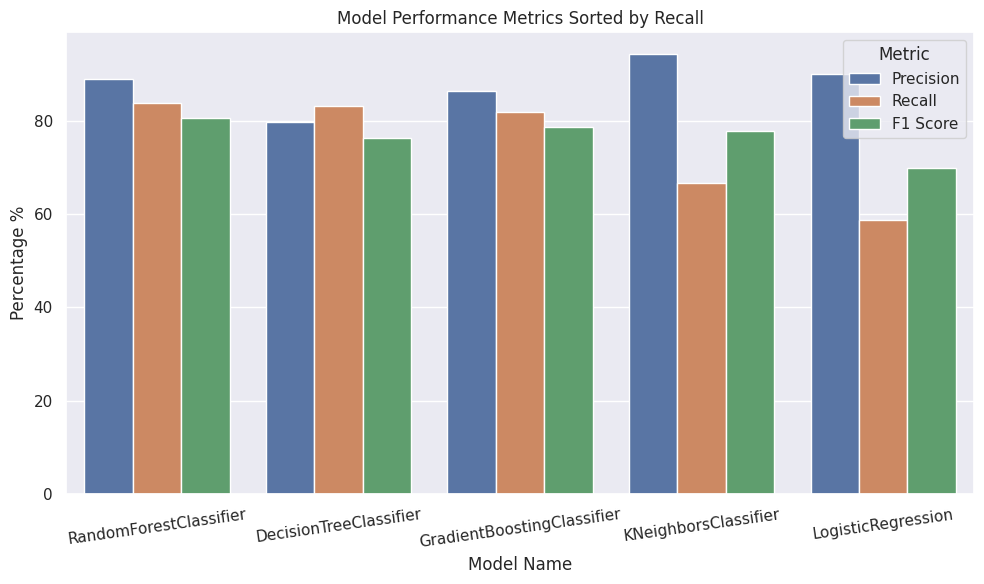

In [77]:

df_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
sorted_models_by_recall = results_df.sort_values(by='Recall', ascending=False)['Model']
sorted_order = sorted_models_by_recall.tolist()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted, order=sorted_order)

plt.title('Model Performance Metrics Sorted by Recall')
plt.ylabel('Percentage %')
plt.xlabel('Model Name')
plt.xticks(rotation=8)
plt.legend(title='Metric')


plt.tight_layout()
plt.show()

### Save best models

In [79]:
selected = ['RandomForestClassifier', 'DecisionTreeClassifier', 'GradientBoostingClassifier']
for name in selected:
    joblib.dump(fit_models[name][1], f'models/{name}.pkl')
    print(f"Saved {name} model.")

Saved RandomForestClassifier model.
Saved DecisionTreeClassifier model.
Saved GradientBoostingClassifier model.


### Load models

In [80]:
RFC = joblib.load("models/RandomForestClassifier.pkl")
GBC = joblib.load("models/GradientBoostingClassifier.pkl")
DTC = joblib.load("models/DecisionTreeClassifier.pkl")

### Grid search for RandomForestClassifier

- n_estimators: number of trees
- max_features: features to use
- min_samples_leaf: reduces overfitting by regularizing trees

In [81]:
forest_params = [
    {
        'n_estimators': [100, 300, 500, 100],
        'max_features': [0.4, 0.6, 'sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 3, 5]
    }
]


RFC_grid_search = GridSearchCV(
    RFC, 
    forest_params,
    scoring=['recall', 'precision', 'f1'],
    refit='f1',
    n_jobs=-1
)

RFC_grid_search.fit(X_train, y_train)

print(RFC_grid_search.best_params_)
print(RFC_grid_search.best_score_)

KeyboardInterrupt: 

In [ ]:
def evaluate_model(name, model):
    print(f"Evaluating model: {name}")

    # Perform cross-validation and request scoring on all metrics
    scores = cross_validate(model, X, y, cv=10, scoring=['precision', 'recall', 'f1'], return_train_score=False)

    # Calculate the mean of the scores for each metric
    precision_mean = round(scores['test_precision'].mean() * 100, 2)
    recall_mean = round(scores['test_recall'].mean() * 100, 2)
    f1_mean = round(scores['test_f1'].mean() * 100, 2)

    # Append the results
    return({
        "Model": name,
        "Precision": precision_mean,
        "Recall": recall_mean,
        "F1 Score": f1_mean
    })

### Fit finetuned model

In [84]:
rtcFinetunedPipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
    max_features=0.4,
    max_depth=None,
    min_samples_leaf=2,
    criterion="gini",
    random_state=42,
    n_estimators=1000,
    n_jobs=-1,
))

rtcFinetunedPipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=0.4, min_samples_leaf=2,
                                        n_estimators=1000, n_jobs=-1,
                                        random_state=42))])

In [85]:
res = evaluate_model("finetuned_RandomForestClassifier", rtcFinetunedPipeline)
res

Evaluating model: finetuned_RandomForestClassifier
